# Phase estimation algorithm: implementation

This notebook shows how to implement the phase estimation algorithm.

The goal is, given a unitary operator $U$ and an associated eigenvector $|\Psi\rangle$ with eigenvalue $e^{2i\pi \theta}$, to find an estimate of $\theta$.

The main steps of the algorithm are:

- Walsh-Hadamard transformation on the phase register
- Controlled-$U^{2^k}$ gates on the full (phase + data) register
- inverse Quantum Fourier Transform on the phase register

We start by writing the main routine, leaving $U$ as a black box (a ``QRoutine``) that will be specified later:

In [1]:
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import H, QRoutine, RX, Program

def build_pea_routine(U_routine, nbits_phase):
    """
    Construct a phase estimation routine corresponding to a given operator U.
    
    Args:
        U_routine (QRoutine): the quantum routine corresponding to U
        nbits_phase (int): number of bits for phase register
        
    Returns:
        QRoutine: a quantum routine
    """
    nbits_data = U_routine.arity
    
    routine = QRoutine()
    phase_reg = routine.new_wires(nbits_phase)
    data_reg = routine.new_wires(nbits_data)
    
    for qb in range(nbits_phase):
        routine.apply(H, phase_reg[qb])
    
    # very simple (and inefficient) way of implementing c-U^2^j
    for j_ind in range(nbits_phase):
        for _ in range(2**j_ind):
            routine.apply(U_routine.ctrl(), phase_reg[j_ind], data_reg)
   
    # now apply inverse QFT
    routine.apply(IQFT(nbits_phase), phase_reg)
    
    return routine

## A simple example: a rotation, $U = R_z$

We start with a very simple example of operation $U$, namely a rotation around the $Z$ axis.

Let us consider
$$U = R_z(\theta) = e^{-i \theta / 2 \sigma_z}$$

(Can you write its representation as a $2\times 2$ matrix ?)

Since it is diagonal, we already know what to expect: what are the two eigenvalues? What is the output you expect (pay attention to the conventions we used for the QPE algorithm above)?

In [2]:
import numpy as np

alpha = 0.32
# thus should readout theta = alpha / (4pi) = 0.32 / (4 pi) ~ 0.02546

nbits_phase = 10
theta_expected = alpha/(4*np.pi) 
print("Expected output = %s (binary: %s)"%(theta_expected,
                                           bin(int(theta_expected* 2**nbits_phase))))



Expected output = 0.025464790894703257 (binary: 0b11010)


We now define the ``QRoutine`` corresponding to this operation, and generate and execute the corresponding QPE circuit:

In [3]:
myroutine = QRoutine()
myroutine.apply(RX(alpha), 0)

pea_routine = build_pea_routine(myroutine, nbits_phase)

prog = Program()
phase_reg = prog.qalloc(nbits_phase)
data_reg = prog.qalloc(myroutine.arity)
prog.apply(pea_routine, phase_reg, data_reg)
circ = prog.to_circ()

%jsqatdisplay circ

from qat.qpus import get_default_qpu
qpu = get_default_qpu()
res = qpu.submit(circ.to_job()) # could modify job
for sample in res:
    if sample.probability > 0.05:
        print(sample.state, sample.probability)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

|0000011010>|0> 0.24597524918640126
|0000011010>|1> 0.24460992034343623
|1111100110>|0> 0.2459752491864012
|1111100110>|1> 0.24460992034343623


- Why are there also states starting with 1111... ? This is because if $\theta$ is an admissible answer, so is $1 - \theta$.

We can convert the final bitstrings to their decimal representation and check whether they match the expected result:

In [4]:
other_sol = int('1111100110', 2)/2**nbits_phase
print("Other solution:", other_sol)

theta_exp = 1 - alpha/(4*np.pi) 
print("Other theta: %s (compare to 1 - theta = %s)"%(theta_exp, 1 - theta_exp))

Other solution: 0.974609375
Other theta: 0.9745352091052968 (compare to 1 - theta = 0.025464790894703215)


### Refinement: measure only the phase register

Since the information about the phase is contained only in the phase register, we can modify the code above to measure only the phase register:

In [5]:
#from qat.lang.AQASM import QInt
#myroutine = QRoutine()
#myroutine.apply(RX(alpha), 0)

#pea_routine = build_pea_routine(myroutine, nbits_phase)

#prog = Program()
#phase_reg = prog.qalloc(nbits_phase)
#data_reg = prog.qalloc(myroutine.arity)
#prog.apply(pea_routine, phase_reg, data_reg)

#circ = prog.to_circ()

#from qat.qpus import get_default_qpu
#qpu = get_default_qpu()
res = qpu.submit(circ.to_job(qubits=phase_reg)) # measure only phase register
for sample in res:
    if sample.probability > 0.05: # print states with more than 5% probability
        print(sample.state.int/2**nbits_phase, sample.probability)

0.025390625 0.49058516952983755
0.974609375 0.49058516952983744


## Finding the ground-state energy of a Hamiltonian via QPE

We now want to find the ground-state energy of a Hamiltonian $H$ with the QPE algorithm. For this, we choose $$U = e^{-i H}.$$

As a Hermitian operator, any Hamiltonian can always be written as:
$$ H = \sum_k \lambda_k P_k$$
with $P_k$ a tensor product of Pauli matrices (e.g $P_k = X_0 Y_1 = \sigma^x_0 \otimes \sigma^y_1$ or $P_k = Z_0 Z_2 Z_3 = \sigma^z_0 \otimes I_1 \otimes \sigma^z_2 \otimes \sigma^z_3$) and $\lambda_k \in \mathbb{R}$.

To implement the QPE algorithm, we must implement controlled $U^{2^i}$ operations.

The core task consists in implementing $U$ itself as a sequence of known gates.
Since the Pauli terms $P_k$ do not commute in general, $U$ can in principle not be written as a product of exponentials of Pauli products. However, in a so-called "Trotter approximation", we will write

$$e^{-i \sum_k \lambda_k P_k} \approx \prod_{n=1}^{N} \left( \prod_k e^{-i \lambda_k P_k / N} \right ),$$
which becomes exact in the $N\rightarrow \infty$ limit.

Thus, the basic operation that is needed is of the form
$$ R_k(\theta) = \exp\left(-i \frac{\theta}{2} P_k\right),$$

which is not a "simple" gate unless $P_k$ contains only one non-identity Pauli matrix. Yet, it can be decomposed as a sequence of simple gates, as shown in the routine below. It uses only CNOT gates and single-qubit operations.

In [6]:
from qat.lang.AQASM import CNOT, RZ
def construct_Rk_routine(ops, qbits, theta):
    """Implement
    
    .. math::
         R_k(\theta) = \exp\left(-i \frac{\theta}{2} P_k\right)
         
    with P_k a Pauli string
    
    Args:
        ops (str): Pauli operators (e.g X, Y, ZZ, etc.)
        qbits (list<int>): qubits on which they act
        theta (Variable): the abstract variable
        
    Returns:
        QRoutine
        
    Notes:
        the indices of the wires of the QRoutine are relative
        to the smallest index in qbits (i.e always start at qb=0)
    """
    min_qb = min(qbits)
    qbits = [qb - min_qb for qb in qbits]  # everything must be defined relative to 0
    qrout = QRoutine()
    with qrout.compute():
        for op, qbit in zip(ops, qbits):
            if op == "X":
                qrout.apply(H, qbit)
            if op == "Y":
                qrout.apply(RX(np.pi/2), qbit)
        for ind_qb in range(len(qbits)-1):
            qrout.apply(CNOT, qbits[ind_qb], qbits[ind_qb+1])
    qrout.apply(RZ(theta), qbits[-1])
    qrout.uncompute() # uncompute() applies U^dagger,
    # with U the unitary corresponding to the gates applied within the "with XX.compute()" context
    
    return qrout

Let us print out the circuit corresponding to $P_k = Z_1 Y_2 Z_3$: 

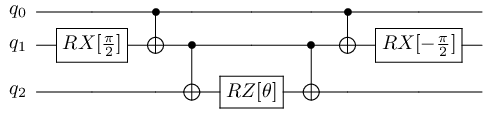

In [7]:
from qat.core import Variable
theta = Variable("\\theta", float)
rotation = construct_Rk_routine("ZYZ", [1, 2, 3], theta)
%qatdisplay rotation

... and here to $P_k = X$:

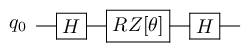

In [8]:
from qat.core import Variable
theta = Variable("\\theta", float)
rotation = construct_Rk_routine("X", [1], theta)
%qatdisplay rotation

(in this simple case, the pattern could be replaced by a $R_X$ gate)

We now construct the full QPE routine:

In [9]:
def build_pea_routine_for_hamiltonian(hamiltonian, n_phase_bits, n_trotter=1):
    """
    Args:
        hamiltonian (Observable): a Hamiltonian
        n_phase_bits (int): the number of phase bits
        n_trotter (int): the number of trotter steps
    
    """
    routine = QRoutine()
    phase_reg = routine.new_wires(n_phase_bits)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    # Hadamard wall
    for qb in range(n_phase_bits):
        routine.apply(H, phase_reg[qb])
    
    # controlled unitaries
    for j_ind in range(n_phase_bits):
        for _ in range(n_trotter):
            for term in hamiltonian.terms:
                theta = term.coeff * 2**(j_ind + 1) / n_trotter
                Rk_routine = construct_Rk_routine(term.op, term.qbits, theta)
                try:
                    routine.apply(Rk_routine.ctrl(), phase_reg[j_ind],
                                  [data_reg[qb] for qb in term.qbits])
                except:
                    print(term.qbits)
                    raise
   
    # now apply inverse QFT
    routine.apply(IQFT(n_phase_bits), phase_reg)
    
    return routine

In [10]:
from qat.lang.AQASM import QInt
def perform_pea(qpu, hamiltonian, psi0, n_phase_bits, n_trotter, verbose=False):
    """
    Args:
        qpu (QPU): a QPU
        hamiltonian (Observable): a Hamiltonian
        psi0 (np.array): an eigenvector of H
        n_phase_bits (int): number of bits for the phase
        n_trotter (int): number of trotter slices
        verbose (bool, optional): for verbose output. Defaults to False.
        
    Returns:
        np.array: the vector of probabilities (frequencies)
    """
    # we prepare the initial state |0...0>|psi0> of the register
    phase_reg_in = np.zeros((2**n_phase_bits,))
    phase_reg_in[0] = 1.0 # |0>^n_phase_bits
    psi_init = np.kron(phase_reg_in, psi0)
    
    # we initialize the program
    prog = Program()
    phase_reg = prog.qalloc(n_phase_bits, class_type=QInt, reverse_bit_order=False)
    data_reg = prog.qalloc(hamiltonian.nbqbits)

    # we use a StatePreparation gate to prepare psi_init
    prog.apply(StatePreparation(psi_init), phase_reg, data_reg)

    # we call the QPE routine
    pea_routine = build_pea_routine_for_hamiltonian(hamiltonian, n_phase_bits, n_trotter=n_trotter)
    prog.apply(pea_routine, phase_reg, data_reg)

    # we generate the corresponding circuit and execute it
    circ = prog.to_circ()
    res = qpu.submit(circ.to_job())

    # we store the output probabilities in a vector
    probs = np.zeros(2**n_phase_bits)
    list_states = []
    for sample in res:
        list_states.append((sample.probability, sample.state))
        probs[sample.state.value[0]] = sample.probability
        
    if verbose:
        # we print the first 5 states (sorted by decreasing probabilities)
        for ind, (prob, state) in enumerate(reversed(sorted(list_states,  key=lambda x: x[0]))):
        
            if ind < 5:
                print(state, state.value[0]/2**n_phase_bits, prob)

    return probs

### A simple test

We now test our routine on a simple Hamiltonian:

$$H = -0.5 X_0 + 0.35 Z_0 Z_1 + 1.5 Z_1.$$

We first construct its matrix representation, which we diagonalize using ``numpy.linalg.eigh`` to know the final result we expect.

In [11]:
from qat.core import Observable, Term
hamiltonian = Observable(2, pauli_terms=[Term(-0.5, "X", [0]), 
                                         Term(0.35, "ZZ", [0, 1]),
                                         Term(1.5, "Z", [1])])
print("H =", hamiltonian)

from util import make_matrix
H_mat = make_matrix(hamiltonian)
eigvals, eigvecs = np.linalg.eigh(H_mat)

ind = 0
psi0 = eigvecs[:, ind]
E0 = eigvals[ind]
theta_expected = -E0/(2*np.pi)

print("Eigvals = ", eigvals)
print("expected theta (-E0/2pi) = ", theta_expected)



H = -0.5 * (X|[0]) +
0.35 * (ZZ|[0, 1]) +
1.5 * (Z|[1])
Eigvals =  [-2.11032778 -0.88967222  0.88967222  2.11032778]
expected theta (-E0/2pi) =  0.3358690978563506


We then execute the QPE algorithm for various values of the number of phase bits and trotter steps $N$:

In [12]:
use_qpu = "pylinalg"

if use_qpu == "pylinalg":
    from qat.qpus import PyLinalg
    from qat.lang.AQASM import AbstractGate
    StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray])
    qpu = PyLinalg()
else:
    from qat.linalg.oracles import StatePreparation
    from qat.qpus import LinAlg
    qpu = LinAlg()

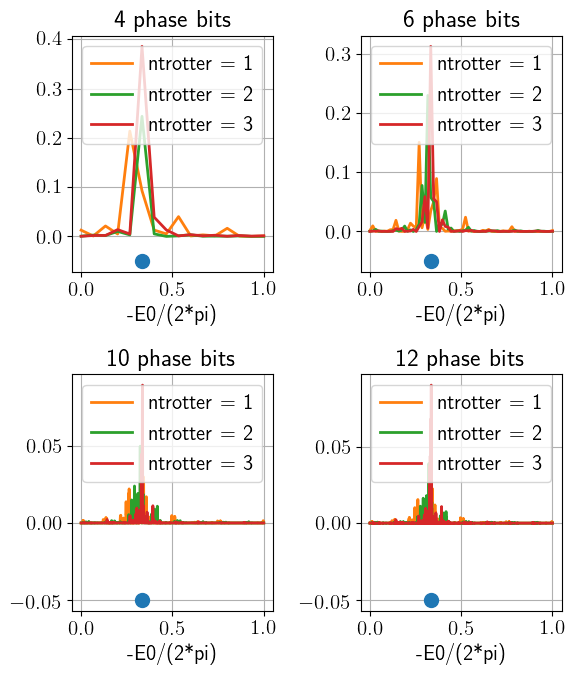

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2)
plt.figure(figsize=(6, 7))

for ind, n_phase_bits in enumerate([4, 6, 10, 12]):
    plt.subplot(gs[ind])
    plt.title(r"%s phase bits"%n_phase_bits)

    plt.plot([theta_expected], [-0.05], 'o', ms=10)
    for n_trotter in [1, 2, 3]:
        probs = perform_pea(qpu, hamiltonian, psi0, n_phase_bits, n_trotter)

        plt.plot(np.linspace(0, 1, 2**n_phase_bits), probs, label=r"ntrotter = %s"%n_trotter)
    plt.grid()
    plt.legend(loc="best")
    plt.xlabel(r"-E0/(2*pi)")
plt.tight_layout()